# ETTh1에 대해서 수행

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_forecasting.metrics import SMAPE,MAE,RMSE
from captum.attr import IntegratedGradients,NoiseTunnel

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 모델 구성하기
* 이전과 다르게 sequence_length를 720 즉 30일을 바라봄

In [2]:
def MSE(pred,target):
    return torch.mean((pred-target)**2,dim = 0) # reduction까지 취해줌

In [3]:
data = pd.read_csv('../../GeneralData/ETTh2.csv')
sequence_length = 720
pred_len = 360

## 2. Sequence중에 빈 시간이 없나 Check

In [4]:
import datetime as dt

In [5]:
data['date'] = pd.to_datetime(data['date'])
for i in range(data.shape[0]-1):
    if data['date'].iloc[i]+dt.timedelta(hours = 1) == data['date'].iloc[i+1]: continue        
    else: print(i)

### &rightarrow; 빈시간 없음

In [6]:
data = data[['OT']]

In [7]:
data

,OT
0,38.661999
1,37.124001
2,36.465000
3,33.608501
4,31.850500
...,...
17415,47.084999
17416,48.183498
17417,48.183498
17418,46.865501


<AxesSubplot: >

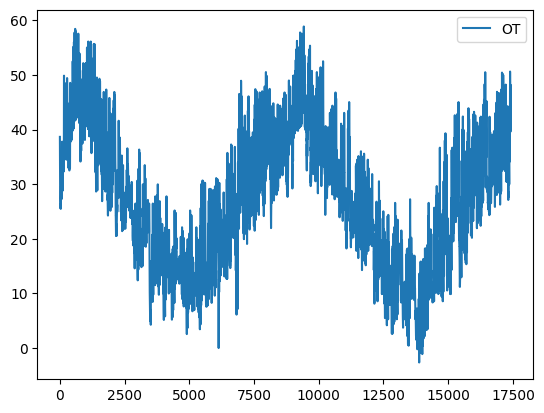

In [8]:
data.plot()

In [9]:
from torch import FloatTensor as FloatTensor

In [10]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    for i in range(0,len(x)-sequence_length-pred_len+1):
        seq_list.append(x.iloc[i:i+sequence_length].values)
        target_list.append(x.iloc[i+sequence_length:i+sequence_length+pred_len].values)
        
    return FloatTensor(seq_list).view(-1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,pred_len).to(device)

In [11]:
split = 24*7 # 24시간 x 7로써 1주일을 테스트셋으로 만듦

In [12]:
seed = 42

In [13]:
device = torch.device("cuda:0")

In [14]:
class Model(nn.Module):
    def __init__(self,train_index):
        super().__init__()
        self.seq_len = len(train_index)
        self.pred_len = 360
        self.train_index = train_index
        
        self.first_layer = nn.Linear(self.seq_len,self.seq_len//2)
        self.second_layer = nn.Linear(self.seq_len//2,self.pred_len)
#         self.third_layer = nn.Linear(self.seq_len//4,self.pred_len)
        
        self.first_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.seq_len//2,self.seq_len]))
        self.second_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len//2]))
#         self.third_layer.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len//4]))
    def forward(self,x):
        first_result = self.first_layer(x[:,self.train_index]) 
        final_result = self.second_layer(first_result)
#         final_result = self.third_layer(second_result)
        return final_result

# 3. Train-Validation set으로 쪼개기

In [15]:
data

,OT
0,38.661999
1,37.124001
2,36.465000
3,33.608501
4,31.850500
...,...
17415,47.084999
17416,48.183498
17417,48.183498
17418,46.865501


* 17420개 중 일주일치 데이터인 168개의 데이터를 Test Set
* 17252개 중 0.2의 비율인 3450개는 validation set
* 17252개 중 0.8의 비율인 13802개는 train set

In [16]:
val_num = 3450

In [17]:
train = data.iloc[:-split-val_num]
val = data.iloc[-split-val_num:-split]
x_train,y_train = seq_data(train, sequence_length = sequence_length, pred_len = pred_len)
x_val,y_val = seq_data(val, sequence_length = sequence_length, pred_len = pred_len)
train_dataset = TensorDataset(x_train,y_train)
val_dataset = TensorDataset(x_val,y_val)
training = DataLoader(train_dataset,batch_size=64)
validation = DataLoader(val_dataset,batch_size=64)

/tmp/ipykernel_845138/3825588569.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,pred_len).to(device)


In [18]:
next(iter(validation))[0].size()

torch.Size([64, 720])

### 위와 같은 방식으로 validation-set에 대해서 기여도를 구하면 될 것이다.
-> 모든 batch의 각 sample에 대해서 Ig를 통한 attribution을 구해서 모든 batch에 걸쳐서 더한후 그것을 평균시킨다.<br>
-> 결과적으로 모든 validation set에 대한 attribution을 평균한다.

In [19]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
train_index = np.arange(sequence_length)
model = Model(train_index).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
num_epochs = 100
n= len(training)

### 기본 모델 training

In [20]:
import copy

In [21]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
minimal_loss=np.inf
for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for inputs, labels in training:
        # forward pass
        inputs = inputs
        outputs = model(inputs)
#         print(outputs.size())
        outputs = outputs.view(-1,1)    
        labels = labels.view(-1,1)
        
        # defining loss
        loss = MSE(outputs, labels)
        # zero the parameter gradients
        optimizer.zero_grad()
        # computing gradients
        loss.backward()
        # accumulating running loss
        running_loss += loss.item()
        # updated weights based on computed gradients
        optimizer.step()
    if epoch % 20 == 0:    
        print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %(epoch + 1, num_epochs, (running_loss/n)*100))
    if (running_loss/n)*100<minimal_loss:
        best_model = copy.deepcopy(model)
        minimal_loss = (running_loss/n)*100
        print("changed")

model = best_model

Epoch [1]/[100] running accumulative loss across all batches: 5307.219
changed
changed
Epoch [21]/[100] running accumulative loss across all batches: 5660.593
changed
changed
changed
changed
Epoch [41]/[100] running accumulative loss across all batches: 4261.710
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
Epoch [61]/[100] running accumulative loss across all batches: 3689.246
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
Epoch [81]/[100] running accumulative loss across all batches: 3546.478
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed


### validation set에 대해서 attribution 구하기

In [22]:
n = len(validation)
n

38

In [23]:
cnt = 0
ig = IntegratedGradients(model)
nt_ig = NoiseTunnel(ig)
nt_ig_attr_score = torch.zeros((pred_len,sequence_length)).to(device)
for val in validation: # validation dataloader
    temp_n = val[0].size(0)
    for i in range(pred_len): # target 0에 대한 영향부터 pred_len에 대한 영향까지 모두 더해서 평균적인 영향도를 측정
        temp = nt_ig.attribute(val[0],target=(i,)).sum(axis = 0) # axis=0으로 batch axis를 기준으로 다 더했음 각 feature의 영향도를 계산 위해
        nt_ig_attr_score[i] = nt_ig_attr_score[i]+temp
    cnt = cnt + temp_n
nt_ig_attr_score = nt_ig_attr_score/cnt
nt_ig_attr_score = nt_ig_attr_score.mean(axis = 0)
nt_ig_attr_score = nt_ig_attr_score.cpu().numpy().reshape(-1)

In [24]:
len(nt_ig_attr_score)

720

<AxesSubplot: >

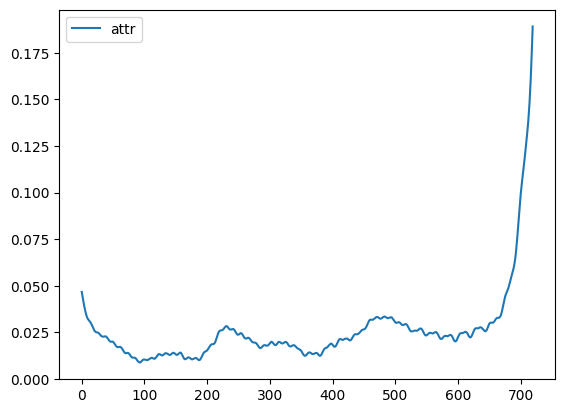

In [25]:
attr_df = pd.DataFrame({'attr':nt_ig_attr_score})
attr_df.plot()

<AxesSubplot: >

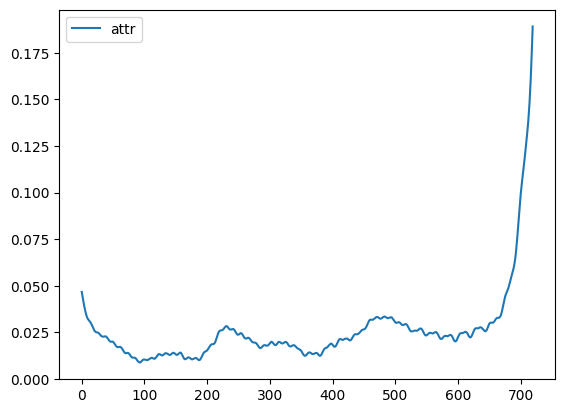

In [26]:
attr_df = attr_df.abs()
attr_df.plot()

## Outlier정의

In [27]:
IQR = 1.5*(attr_df.quantile(0.75)-attr_df.quantile(0.25))
outlier_max = attr_df.quantile(0.75)+IQR
outlier_min = attr_df.quantile(0.25)-IQR
candidate_attr = attr_df[(attr_df>=outlier_min) & (attr_df<=outlier_max)]
candidate_attr = candidate_attr.dropna()
candidate_attr

,attr
2,0.042712
3,0.040796
4,0.039002
5,0.037346
6,0.035873
...,...
670,0.036324
671,0.037907
672,0.039610
673,0.041289


<AxesSubplot: >

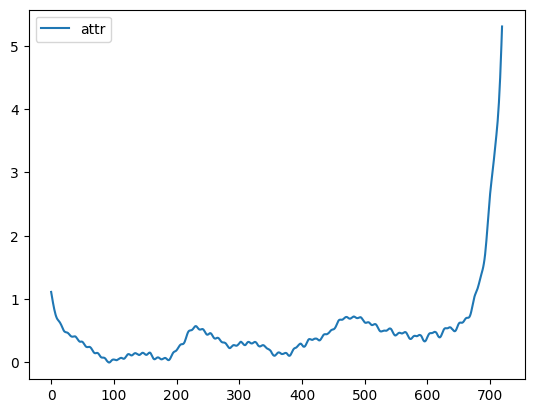

In [28]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
scaler.fit(candidate_attr.values)
m_attr_df = scaler.transform(attr_df.values)
m_attr_df = pd.DataFrame({"attr":m_attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
m_attr_df.plot()

In [29]:
m_attr_df.describe()

,attr
count,720.000000
mean,0.502200
std,0.633247
min,0.000000
25%,0.221102
50%,0.391451
75%,0.537597
max,5.305327


<AxesSubplot: >

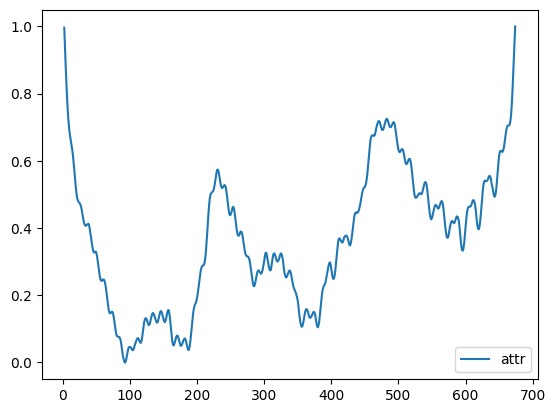

In [30]:
m_attr_df[(m_attr_df>=0) & (m_attr_df<=1)].dropna().plot()

<AxesSubplot: >

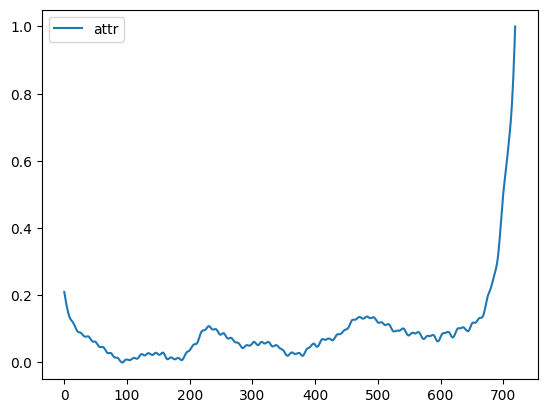

In [31]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
scaler = MinMaxScaler()
attr_df = scaler.fit_transform(attr_df.values)
attr_df = pd.DataFrame({"attr":attr_df.reshape(-1)})
# attr_df = attr_df.abs()
# attr_std = attr_df.std().item()
# attr_min = attr_df.min().item()
attr_df.plot()

#### train_index구하기

In [32]:
index_list = []

for hyper_para in np.arange(0.00,1.01,0.01):
    append_idx = list(m_attr_df[(m_attr_df['attr']>=hyper_para)].index)
    index_list.append(append_idx)
len(index_list) # train_index의 리스트

101

In [33]:
len_list=[]
for i in range(100):
    len_list.append(len(index_list[i]))


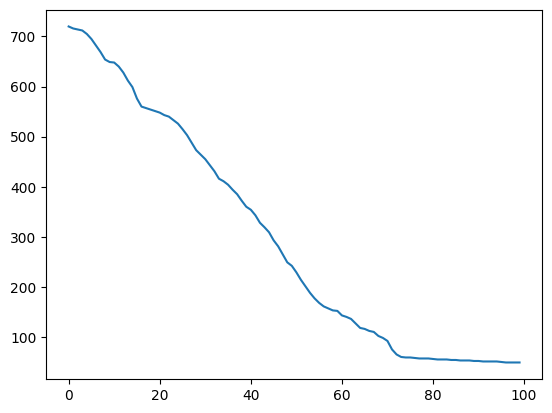

In [34]:
plt.plot(np.arange(100),len_list) # 포함되는 time_index의 갯수

In [35]:
for val_x,val_y in validation:
    print(val_x,val_y)

tensor([[ 3.9455,  3.9455,  3.5055,  ..., 14.7120, 13.8330, 12.9540],
        [ 3.9455,  3.5055,  3.5055,  ..., 13.8330, 12.9540, 12.5145],
        [ 3.5055,  3.5055,  3.2860,  ..., 12.9540, 12.5145, 12.0750],
        ...,
        [ 8.9990,  8.7795,  7.6805,  ..., 16.6890, 16.9090, 17.7880],
        [ 8.7795,  7.6805,  6.5820,  ..., 16.9090, 17.7880, 18.2275],
        [ 7.6805,  6.5820,  5.2640,  ..., 17.7880, 18.2275, 19.3265]],
       device='cuda:0') tensor([[12.5145, 12.0750, 11.1965,  ..., 23.5010, 22.8420, 21.9630],
        [12.0750, 11.1965, 10.7570,  ..., 22.8420, 21.9630, 21.0840],
        [11.1965, 10.7570, 10.3175,  ..., 21.9630, 21.0840, 20.6450],
        ...,
        [18.2275, 19.3265, 19.5460,  ..., 29.8730, 31.1910, 33.8280],
        [19.3265, 19.5460, 19.3260,  ..., 31.1910, 33.8280, 35.1465],
        [19.5460, 19.3260, 18.4470,  ..., 33.8280, 35.1465, 35.3660]],
       device='cuda:0')
tensor([[ 6.5820,  5.2640,  4.1650,  ..., 18.2275, 19.3265, 19.5460],
        [ 5.26

       device='cuda:0') tensor([[38.1980, 41.7135, 42.8125,  ..., 32.4610, 33.3400, 34.6580],
        [41.7135, 42.8125, 43.9110,  ..., 33.3400, 34.6580, 35.0975],
        [42.8125, 43.9110, 43.9110,  ..., 34.6580, 35.0975, 35.3170],
        ...,
        [42.3730, 41.4940, 40.6155,  ..., 33.7790, 33.7790, 33.7790],
        [41.4940, 40.6155, 38.8575,  ..., 33.7790, 33.7790, 33.7790],
        [40.6155, 38.8575, 37.5390,  ..., 33.7790, 33.7790, 28.9205]],
       device='cuda:0')
tensor([[18.8625, 18.2030, 17.9835,  ..., 42.3730, 41.4940, 40.6155],
        [18.2030, 17.9835, 17.7635,  ..., 41.4940, 40.6155, 38.8575],
        [17.9835, 17.7635, 17.5440,  ..., 40.6155, 38.8575, 37.5390],
        ...,
        [43.9110, 42.3730, 40.8350,  ..., 31.3625, 31.3625, 31.3625],
        [42.3730, 40.8350, 39.2970,  ..., 31.3625, 31.3625, 31.1425],
        [40.8350, 39.2970, 37.0995,  ..., 31.3625, 31.1425, 31.1425]],
       device='cuda:0') tensor([[38.8575, 37.5390, 33.8035,  ..., 33.7790, 28.9205, 

In [36]:
val_x

tensor([[30.5075, 30.5075, 30.5075,  ..., 46.9145, 44.2775, 41.6405],
        [30.5075, 30.5075, 30.5075,  ..., 44.2775, 41.6405, 39.4430],
        [30.5075, 30.5075, 30.5075,  ..., 41.6405, 39.4430, 37.4660]],
       device='cuda:0')

In [37]:
### 원래 난수가 선언된 위치
m = len(validation)
n = len(training)
cnt = 0
num_epochs = 100
mse_out_list = []
mae_out_list = []
smape_out_list = []
rmse_out_list = []
for idx in index_list: #0.01~1.00 100개의 index에 대해서 수행
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed) # 난수 선언(원래는 cnt선언 위에 있었다)
    train_idx = idx
    minimal_loss=np.inf
    model = Model(train_idx).to(device) # 모델 초기화
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # optimizer 초기화
    result = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in training:
            # forward pass
            inputs = inputs
            
            outputs = model(inputs)
            outputs = outputs.view(-1,1)
            labels = labels.view(-1,1)            
            # defining loss
            loss = MSE(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch == 99:    
            print(f'{cnt}번째 모델 Training 완료 마지막 Epoch loss:{(running_loss/n)*100}')
        
        if (running_loss/n)*100<minimal_loss:
            best_model = copy.deepcopy(model)
            minimal_loss = (running_loss/n)*100
            print("changed")

    model = best_model
    cnt+=1
    # 모델 Fully-Training 완료
    
    pred = torch.FloatTensor().to(device)
    val_target = torch.FloatTensor().to(device)
    for val_x,val_y in validation:
        tmp_pred = model(val_x)
        pred = torch.concat([pred,tmp_pred], dim=0)
        val_target = torch.concat([val_target,val_y],dim = 0)
    pred = pred.view(-1,1)
    val_target = val_target.view(-1,1)
    result = MSE(pred,val_target).item()
    mse_out_list.append(result)
    mae_out_list.append(MAE()(pred,val_target).item())
    rmse_out_list.append(RMSE()(pred,val_target).item())
    smape_out_list.append(SMAPE()(pred,val_target).item()*100)

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
0번째 모델 Training 완료 마지막 Epoch loss:3461.2847088569374
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
1번째 모델 Training 완료 마지막 Epoch loss:3456.3538891586227
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
change

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
25번째 모델 Training 완료 마지막 Epoch loss:3171.341998852677
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
26번째 모델 Training 완료 마지막 Epoch loss:3165.925722984812
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
change

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
47번째 모델 Training 완료 마지막 Epoch loss:3225.319616758644
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
48번째 모델 Training 완료 마지막 Epoch loss:3475.8257827567095
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
49번째 모델 Training 완료 마지막 Epoch loss:3612.1755480167253
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
50번째 모델 Training 완료 마지막 Epoch loss:3628.474999432588
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
51번째 모델 Training 완료 마지막 Epoch loss:3682.29

changed
changed
changed
61번째 모델 Training 완료 마지막 Epoch loss:3907.631873365623
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
62번째 모델 Training 완료 마지막 Epoch loss:3904.693335144963
changed
changed
changed
changed
changed
changed
changed
changed
change

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
71번째 모델 Training 완료 마지막 Epoch loss:3923.365326023581
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
81번째 모델 Training 완료 마지막 Epoch loss:4231.251692652104
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
cha

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
90번째 모델 Training 완료 마지막 Epoch loss:4236.722097444774
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
91번째 모델 Tra

changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
changed
100번째 모델 Training 완료 마지막 Epoch loss:4249.114411799752
changed


In [38]:
val_y # 다음 예측 타겟값

tensor([[39.4430, 37.4660, 36.1475,  ..., 36.8070, 36.3670, 34.1700],
        [37.4660, 36.1475, 35.4880,  ..., 36.3670, 34.1700, 32.1925],
        [36.1475, 35.4880, 34.6090,  ..., 34.1700, 32.1925, 30.4345]],
       device='cuda:0')

In [39]:
val_x # 예측 하는 값

tensor([[30.5075, 30.5075, 30.5075,  ..., 46.9145, 44.2775, 41.6405],
        [30.5075, 30.5075, 30.5075,  ..., 44.2775, 41.6405, 39.4430],
        [30.5075, 30.5075, 30.5075,  ..., 41.6405, 39.4430, 37.4660]],
       device='cuda:0')

In [40]:
result/68

1.2945575714111328

In [41]:
val_x.size()

torch.Size([3, 720])

           out
100  88.029915


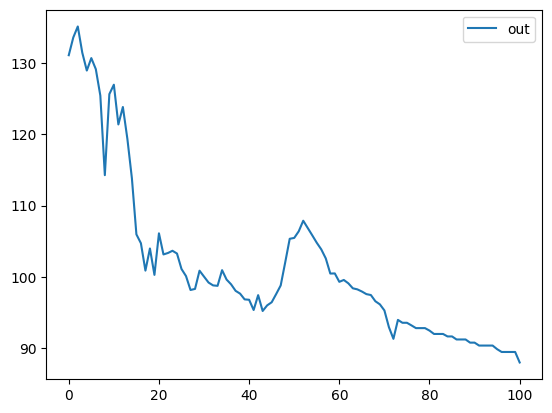

In [42]:
out_df = pd.DataFrame({"out":mse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [43]:
out_df

,out
0,131.054672
1,133.535385
2,135.077332
3,131.399368
4,128.907913
...,...
96,89.500801
97,89.500801
98,89.500801
99,89.500801


          out
100  7.397265


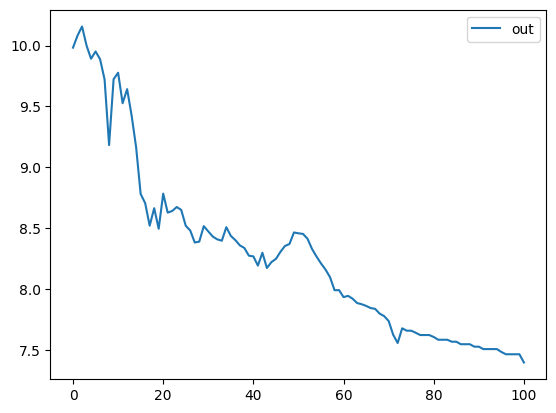

In [44]:
out_df = pd.DataFrame({"out":mae_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [45]:
out_df

,out
0,9.983355
1,10.082176
2,10.157108
3,10.000779
4,9.892076
...,...
96,7.464692
97,7.464692
98,7.464692
99,7.464692


           out
100  28.958815


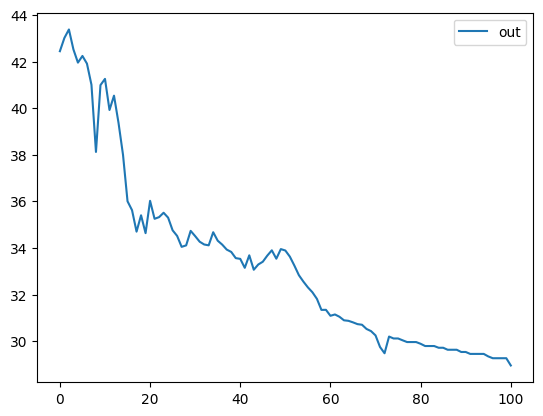

In [46]:
out_df = pd.DataFrame({"out":smape_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

In [47]:
out_df

,out
0,42.444527
1,43.014297
2,43.376923
3,42.521891
4,41.954616
...,...
96,29.270118
97,29.270118
98,29.270118
99,29.270118


In [ ]:
out_df = pd.DataFrame({"out":rmse_out_list})

out_df.plot()

print(out_df[out_df['out']==out_df['out'].min()])

          out
100  9.382426

In [ ]:
out_df

In [ ]:
attr_df.describe()